Analyzing feature importance for survival in Titanic dataset
Comparing performance of classification models

In [118]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay


## Michael Owen

## Exploring, preparing, and testing various classsifiers on the Titanic dataset. 
- This will be my first deep dive into the Titanic dataset - which is a dataset that I find fascinating as the outcome (survived or not) is clearly correlated to certain features; specifically societal and social variables like: sex, age, family/wealth/class. It isn't a massive dataset, but it is large and balanced enough that it poses as a decent test for classifiers we've explored in this course. It also requires some preprocessing, scaling and encoding - which means I can make use of some of the preprocessing techniques taught throughout the quarter. While this was a horrible tragedy that we wish never occurred, the resulting data from the tragedy makes for an interesting social experiment/analysis/investigation. Additionally, many 'new' datasets nowawdays rely on classifiers that are somewhat of a 'black box'. Here we can explore variables, test their importance by classifier, and make reasonable interpretations. 

In [119]:
def plot_feature_importances(model_in, df_in):
    n_features = df_in.shape[1]
    df_colnames= df_in.columns
    plt.barh(np.arange(n_features), model_in.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), df_colnames)
    plt.xlabel("Feature importance")
    plt.ylim(-1, n_features)
    plt.show()

- The dataset can be retrieved from sklearn.datasets using fetch_openml

In [120]:
titanic = fetch_openml('titanic', version=1, as_frame=True)
df = titanic['data']
df['survived'] = titanic['target']
df.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0


In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   name       1309 non-null   object  
 2   sex        1309 non-null   category
 3   age        1046 non-null   float64 
 4   sibsp      1309 non-null   float64 
 5   parch      1309 non-null   float64 
 6   ticket     1309 non-null   object  
 7   fare       1308 non-null   float64 
 8   cabin      295 non-null    object  
 9   embarked   1307 non-null   category
 10  boat       486 non-null    object  
 11  body       121 non-null    float64 
 12  home.dest  745 non-null    object  
 13  survived   1309 non-null   category
dtypes: category(3), float64(6), object(5)
memory usage: 116.8+ KB


### Check for nulls: 
- Many nulls for age, cabin, boat, body, home.dest
- Some of these features with higher amounts of nulls can likely be dropped. While certain features like age can be scaled according to the rest of the dataset

In [122]:
df.isnull().sum()

pclass          0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
survived        0
dtype: int64

### Visualize rate of missing values per variable:

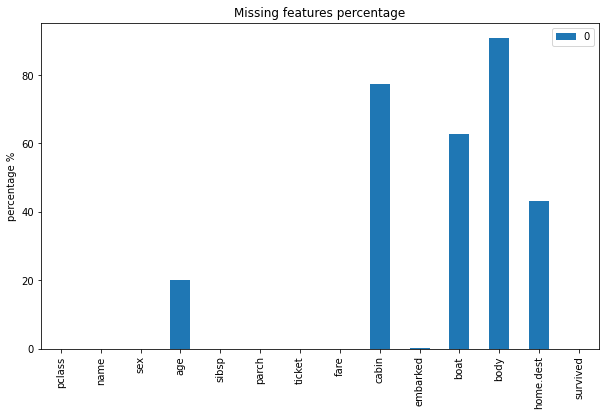

In [123]:
nullVals = pd.DataFrame(df.isnull().sum() / len(df) * 100)
nullVals.plot(kind='bar',title='Missing features percentage', ylabel='percentage %',figsize=(10,6))
plt.show()

In [124]:
df.describe()

,pclass,age,sibsp,parch,fare,body
count,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,80.000000,8.000000,9.000000,512.329200,328.000000


#### Using Parch and sibsP we should be able to determine whether passenger has family. Will do this later.

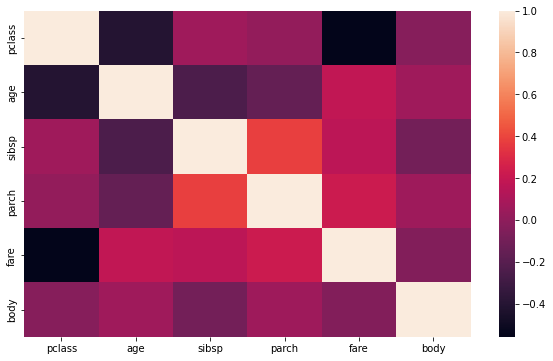

In [125]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr())
plt.show()

In [126]:
labelCounts = df.survived.value_counts()
labelCounts

0    809
1    500
Name: survived, dtype: int64

### In this dataset, 500 people survived while 809 did not
#### Visualize this count via bar plot:

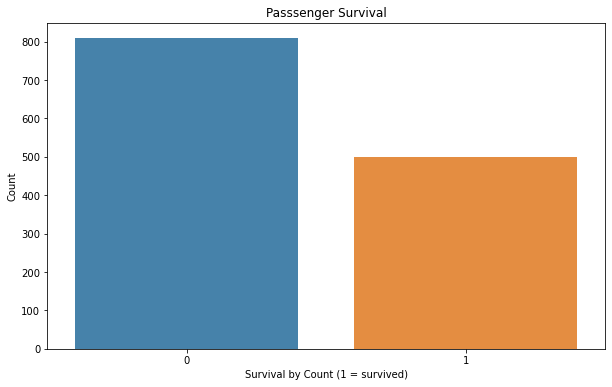

In [127]:
plt.figure(figsize=(10,6))
sns.barplot(x = labelCounts.index, y= labelCounts.values, alpha = 0.9)
plt.xlabel('Survival by Count (1 = survived)')
plt.ylabel('Count')
plt.title('Passsenger Survival')
plt.show()

### Dropping variables that are either not important and/or have too many missing values

In [128]:
df.drop(labels = ["cabin", "ticket","body","boat","home.dest"], axis = 1, inplace = True)
df.isnull().sum()

pclass        0
name          0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
survived      0
dtype: int64

In [129]:
df.head()

,pclass,name,sex,age,sibsp,parch,fare,embarked,survived
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,211.3375,S,1
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,151.5500,S,1
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,151.5500,S,0
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,151.5500,S,0
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,151.5500,S,0


### Based on the below plot It appears that most people were between the ages of 20 and 30. Will confirm by taking the mean and median (median should be more representive)

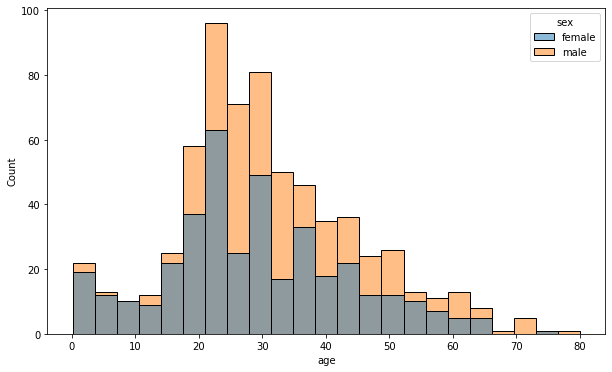

In [130]:
plt.figure(figsize=(10,6))
sns.histplot(x='age', hue = 'sex', data = df)
plt.show()

In [131]:
print("Mean age:",df['age'].mean())
print("Median age:",df['age'].median())

Mean age: 29.8811345124283
Median age: 28.0


In [132]:
df.embarked.value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

### Now we will do some more pre-processsing to handle remaining missing values, categorical values, etc:
- Since S is clearly the most frequent port of embarkment (shown above), we will use that to fill Na's for that variable
- Median age for missing age variable
- Median fare for missing fares

In [133]:
df["age"].fillna(df["age"].median(), inplace = True)
df["fare"].fillna(df["fare"].median(), inplace = True)
df["embarked"].fillna("S", inplace = True)

In [134]:
df.isnull().sum()

pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
fare        0
embarked    0
survived    0
dtype: int64

### Survival rate by gender, as a distribution:

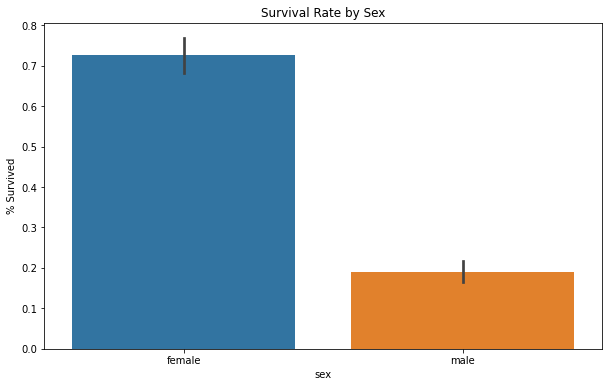

In [135]:
plt.figure(figsize=(10,6))
df['survived'] = df.survived.astype('int')
sns.barplot(x='sex',y='survived',data=df)
plt.ylabel("% Survived")
plt.title('Survival Rate by Sex')
plt.show()

### Survival rate by class

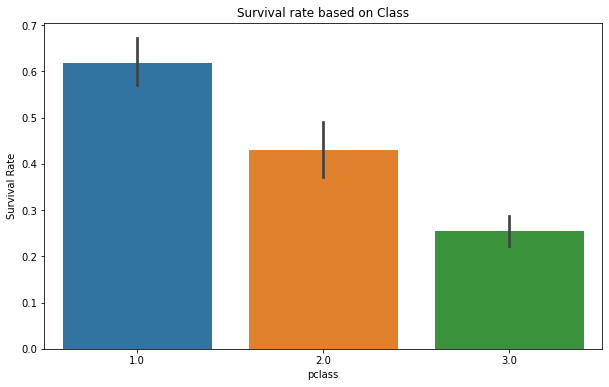

In [136]:
plt.figure(figsize=(10,6))
sns.barplot(x="pclass", y="survived", data=df)
plt.ylabel("Survival Rate")
plt.title("Survival rate based on Class")
plt.show()

### The below plots visualize survival rate with both sex and class considered

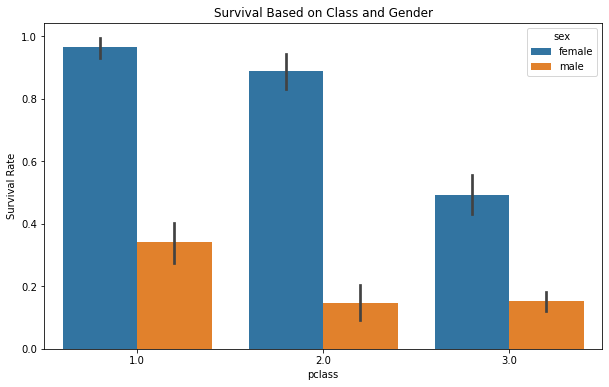

In [137]:
plt.figure(figsize=(10,6))
sns.barplot(x="pclass", y="survived", hue="sex", data=df)
plt.ylabel("Survival Rate")
plt.title("Survival Based on Class and Gender")
plt.show()

### Class not a huge indicator of survival rate for males 

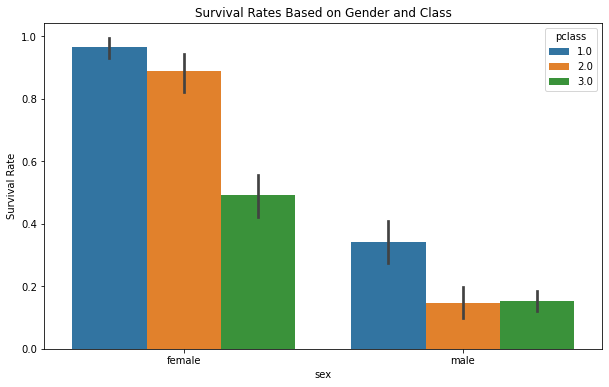

In [138]:
plt.figure(figsize=(10,6))
sns.barplot(x="sex", y="survived", hue="pclass", data=df)
plt.ylabel("Survival Rate")
plt.title("Survival Rates Based on Gender and Class")
plt.show()

### Survival rate based on the port the person embarked from

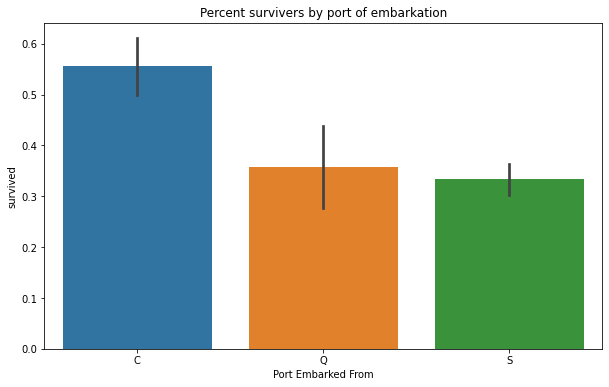

In [139]:
plt.figure(figsize=(10,6))
sns.barplot(x='embarked', y='survived', data=df)
plt.title('Percent survivers by port of embarkation')
plt.xlabel("Port Embarked From")
plt.show()

### Now we will add a new feature 'traveled_alone' by making use of the existing - features sibsP and parch - to determine whether a person had family with them

In [140]:
df['family_aboard'] = df['sibsp'] + df['parch']
df.loc[df['family_aboard'] == 0, 'alone'] = 1
df.loc[df['family_aboard'] > 0, 'alone'] = 0

In [141]:
df.drop(['family_aboard', 'sibsp', 'parch','name'], axis=1, inplace=True)

In [142]:
df.head()

,pclass,sex,age,fare,embarked,survived,alone
0,1.0,female,29.0000,211.3375,S,1,1.0
1,1.0,male,0.9167,151.5500,S,1,0.0
2,1.0,female,2.0000,151.5500,S,0,0.0
3,1.0,male,30.0000,151.5500,S,0,0.0
4,1.0,female,25.0000,151.5500,S,0,0.0


### Scaling numerical features so that there isn't such a large gap between variables

In [143]:
scaler = StandardScaler()
ages = np.array(df["age"]).reshape(-1, 1)
fares = np.array(df["fare"]).reshape(-1, 1)
df["age"] = scaler.fit_transform(ages)
df["fare"] = scaler.fit_transform(fares)
df.head()

,pclass,sex,age,fare,embarked,survived,alone
0,1.0,female,-0.039005,3.442584,S,1,1.0
1,1.0,male,-2.215952,2.286639,S,1,0.0
2,1.0,female,-2.131977,2.286639,S,0,0.0
3,1.0,male,0.038512,2.286639,S,0,0.0
4,1.0,female,-0.349075,2.286639,S,0,0.0


### Encoding remaining categorical features to numerical before model testing

In [144]:
le_sex = LabelEncoder()
le_sex.fit(df["sex"])

encoded_sex = le_sex.transform(df["sex"])
df["sex"] = encoded_sex
le_embarked = LabelEncoder()
le_embarked.fit(df["embarked"])

encoded_embarked = le_embarked.transform(df["embarked"])
df["embarked"] = encoded_embarked
df.head()

,pclass,sex,age,fare,embarked,survived,alone
0,1.0,0,-0.039005,3.442584,2,1,1.0
1,1.0,1,-2.215952,2.286639,2,1,0.0
2,1.0,0,-2.131977,2.286639,2,0,0.0
3,1.0,1,0.038512,2.286639,2,0,0.0
4,1.0,0,-0.349075,2.286639,2,0,0.0


# Now for model testing
## All model results and accuracy on test set will be displayed at bottom of the notebook
- Final results will be displayed as a table/dataframe at the bottom of the notebook, followed by concluding thoughts
- I will first run the DecisionTreeClassifier with default params to get a baseline, then I will test 5 models and perform hyperparamter tuning to find the best

In [145]:
X = df.drop('survived', axis=1)
y = df['survived']

In [146]:
RAND_STATE = 32
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RAND_STATE)

## Depending on the model/classifier, we can easily identify feature importance.
- This can't be done for certain classifiers like KNN and SVM (non-linear kernels)

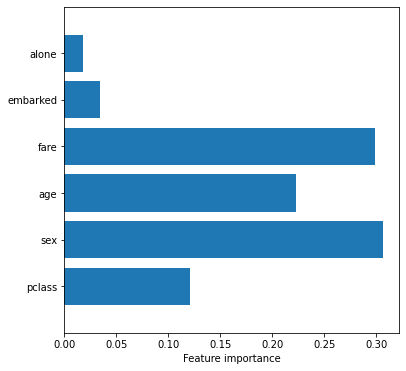

In [147]:
dt_clf = DecisionTreeClassifier(random_state=RAND_STATE)
 
dt_clf.fit(X_train, y_train)
plt.figure(figsize=[6,6])
plot_feature_importances(dt_clf, X_train)

Model Accuracy on Test Set: 0.7735368956743003


Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       226
           1       0.76      0.68      0.72       167

    accuracy                           0.77       393
   macro avg       0.77      0.76      0.76       393
weighted avg       0.77      0.77      0.77       393



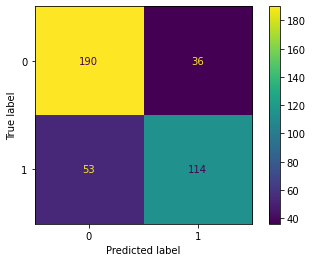

In [148]:
y_pred_dt = dt_clf.predict(X_test)
print(f'Model Accuracy on Test Set: {dt_clf.score(X_test, y_test)}')
print('\n')
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))
ConfusionMatrixDisplay.from_estimator(dt_clf, X_test, y_test)
plt.show()

## Parameter tuning via gridsearch
- Models to be further tested: 
- 1. LogisticRegression
- 2. SVM
- 3. RandomForestClassifer
- 4. KNN
- 5. DecisionTreeClassifier

In [149]:
crossvalscores = { 
    'LogisticRegression': {
        'cv_score': '', 
        'params': '',
        'test_set_score':''
            }, 
         'KNeighborsClassifier': {
              'cv_score': '', 
            'params': '',
             'test_set_score':''
                 },
                'SVC': {
                  'cv_score': '', 
                   'params': '',
                    'test_set_score':''
                 },
                'RandomForestClassifier': {
                  'cv_score': '', 
                   'params': '',
                    'test_set_score':''
                 },
    'DecisionTreeClassifier': {
                  'cv_score': '', 
                   'params': '',
                    'test_set_score':''
                 }
             }

### 1:  LogisticRegression

Best Score 5 fold CV: 0.7783796626277025


Classification Report on test set:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       226
           1       0.76      0.71      0.73       167

    accuracy                           0.78       393
   macro avg       0.77      0.77      0.77       393
weighted avg       0.78      0.78      0.78       393



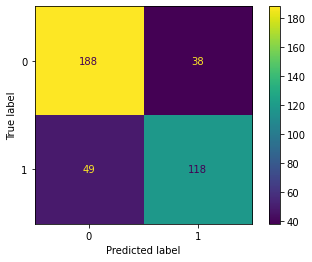

In [150]:
params = { 'C': [0.001, 0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']}
 
lr_clf = LogisticRegression(class_weight='balanced', solver='liblinear',random_state=RAND_STATE)
 
lreg_cv = GridSearchCV(lr_clf, param_grid=params, cv=5,scoring='accuracy')
 
lreg_cv.fit(X_train, y_train)

crossvalscores['LogisticRegression']['cv_score'] = lreg_cv.best_score_
crossvalscores['LogisticRegression']['params'] = lreg_cv.best_params_
crossvalscores['LogisticRegression']['test_set_score'] = lreg_cv.score(X_test, y_test)
y_pred_logr = lreg_cv.predict(X_test)
print("Best Score 5 fold CV:",crossvalscores['LogisticRegression']['cv_score'])
print("\n")
print("Classification Report on test set:")
print(classification_report(y_test, y_pred_logr))
ConfusionMatrixDisplay.from_estimator(lreg_cv, X_test, y_test)
plt.show()

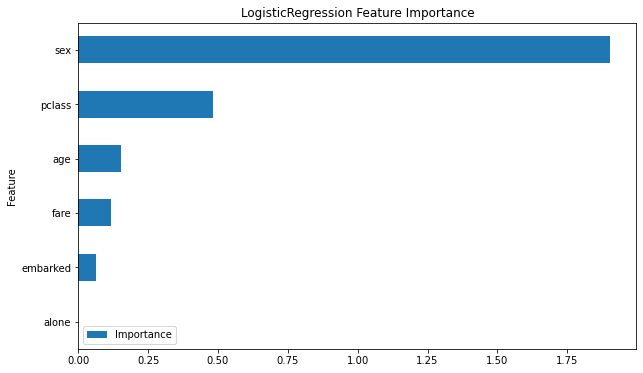

In [151]:
coefficients = lreg_cv.best_estimator_.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': avg_importance})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', title='LogisticRegression Feature Importance', figsize=(10, 6))
plt.show()

#### Clearly sex (male or female) is the most indicative feature of surviving or not for this specific Logistic classifier.
-- Hyperparameters shown at the bottom of notebook in a table after running each model

### 2:  SVM

Best Score 5 fold CV: 0.791488477072939


Classification Report on test set:
              precision    recall  f1-score   support

           0       0.83      0.84      0.84       226
           1       0.78      0.77      0.77       167

    accuracy                           0.81       393
   macro avg       0.81      0.80      0.80       393
weighted avg       0.81      0.81      0.81       393



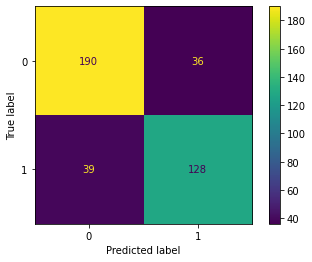

In [152]:
params = {'C': [0.01, 0.1, 1, 10, 15],'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'gamma': ['scale', 'auto']}
 
svc = SVC(class_weight='balanced',probability=True,random_state=RAND_STATE)
 
svc_cv = GridSearchCV(svc, param_grid=params, cv=5, scoring='accuracy', n_jobs=-1)
 
svc_cv.fit(X_train, y_train)
 
crossvalscores['SVC']['cv_score'] = svc_cv.best_score_
crossvalscores['SVC']['params'] = svc_cv.best_params_
crossvalscores['SVC']['test_set_score'] = svc_cv.score(X_test, y_test)
y_pred_svc = svc_cv.predict(X_test)
print("Best Score 5 fold CV:",crossvalscores['SVC']['cv_score'])
print("\n")
print("Classification Report on test set:")
print(classification_report(y_test, y_pred_svc))
ConfusionMatrixDisplay.from_estimator(svc_cv, X_test, y_test)

plt.show()

### 3: RandomForestClassifier

Best Score 5 fold CV: 0.7958660014255168


Classification Report on test set:
              precision    recall  f1-score   support

           0       0.78      0.89      0.83       226
           1       0.81      0.65      0.72       167

    accuracy                           0.79       393
   macro avg       0.79      0.77      0.78       393
weighted avg       0.79      0.79      0.78       393



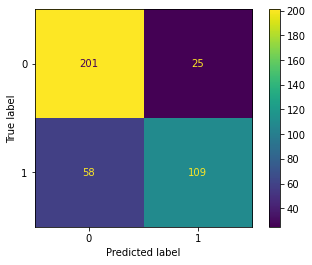

In [153]:
params = {'n_estimators': [5, 10, 15, 20, 25], 'max_depth': [3, 5, 7, 9, 11, 13]}
rf_clf = RandomForestClassifier(class_weight='balanced',random_state=RAND_STATE)
 
rf_cv = GridSearchCV(rf_clf, param_grid=params, cv=5,scoring='accuracy')
 
rf_cv.fit(X_train, y_train)
 
crossvalscores['RandomForestClassifier']['cv_score'] = rf_cv.best_score_
crossvalscores['RandomForestClassifier']['params'] = rf_cv.best_params_
crossvalscores['RandomForestClassifier']['test_set_score'] = rf_cv.score(X_test, y_test)
y_pred_rfc = rf_cv.predict(X_test)
print("Best Score 5 fold CV:", crossvalscores['RandomForestClassifier']['cv_score']) 
print("\n")
print("Classification Report on test set:")
print(classification_report(y_test, y_pred_rfc))
ConfusionMatrixDisplay.from_estimator(rf_cv, X_test, y_test)
plt.show()

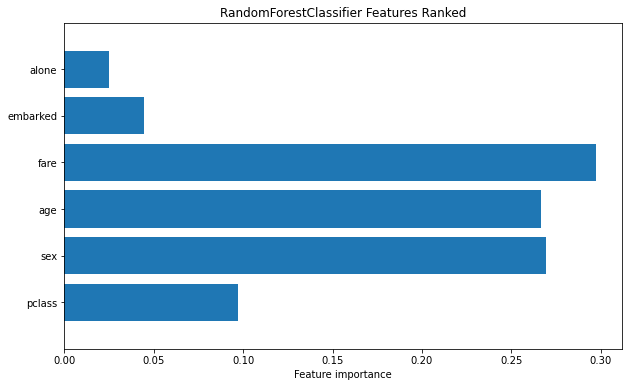

In [154]:
plt.figure(figsize=[10,6])
plt.title("RandomForestClassifier Features Ranked")
plot_feature_importances(rf_cv.best_estimator_, X_train)

### 4: KNN

Best Score 5 fold CV: 0.8013186029935853


Classification Report on test set:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       226
           1       0.83      0.57      0.68       167

    accuracy                           0.77       393
   macro avg       0.79      0.74      0.75       393
weighted avg       0.78      0.77      0.76       393



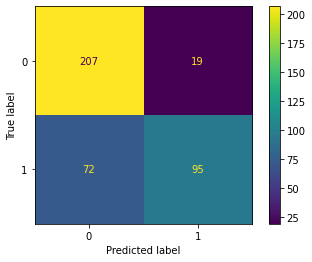

In [155]:
params = {'n_neighbors': np.arange(1, 40)}
 
knn_clf = KNeighborsClassifier()
 
knn_cv = GridSearchCV(knn_clf, param_grid=params, cv=5, scoring='accuracy')
 
knn_cv.fit(X_train, y_train)
 
crossvalscores['KNeighborsClassifier']['cv_score'] = knn_cv.best_score_
crossvalscores['KNeighborsClassifier']['params'] = knn_cv.best_params_
crossvalscores['KNeighborsClassifier']['test_set_score'] = knn_cv.score(X_test, y_test)
y_pred_knn = knn_cv.predict(X_test)
print("Best Score 5 fold CV:", crossvalscores['KNeighborsClassifier']['cv_score'])
print("\n")
print("Classification Report on test set:")
print(classification_report(y_test, y_pred_knn))
ConfusionMatrixDisplay.from_estimator(knn_cv, X_test, y_test)
plt.show()

### 5: DecisionTreeClassifier

Best Score 5 fold CV: 0.7980458541221193


Classification Report on test set:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       226
           1       0.72      0.77      0.75       167

    accuracy                           0.78       393
   macro avg       0.77      0.78      0.78       393
weighted avg       0.78      0.78      0.78       393



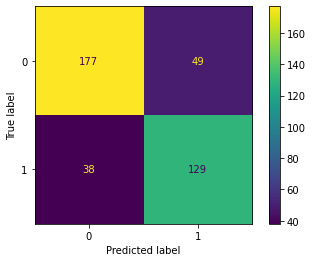

In [156]:
params = {'max_depth': [2, 3, 5, 7, 9, 11]}
 
dtclf = DecisionTreeClassifier(class_weight='balanced',random_state=RAND_STATE)
 
dt_cv = GridSearchCV(dtclf, param_grid=params, cv=5,scoring='accuracy')
 
dt_cv.fit(X_train, y_train)
 
crossvalscores['DecisionTreeClassifier']['cv_score'] = dt_cv.best_score_
crossvalscores['DecisionTreeClassifier']['params'] = dt_cv.best_params_
crossvalscores['DecisionTreeClassifier']['test_set_score'] = dt_cv.score(X_test, y_test)
y_pred_dtc = dt_cv.predict(X_test)
print("Best Score 5 fold CV:",crossvalscores['DecisionTreeClassifier']['cv_score'])
print("\n")
print("Classification Report on test set:")
print(classification_report(y_test, y_pred_dtc))
ConfusionMatrixDisplay.from_estimator(dt_cv, X_test, y_test)
plt.show()

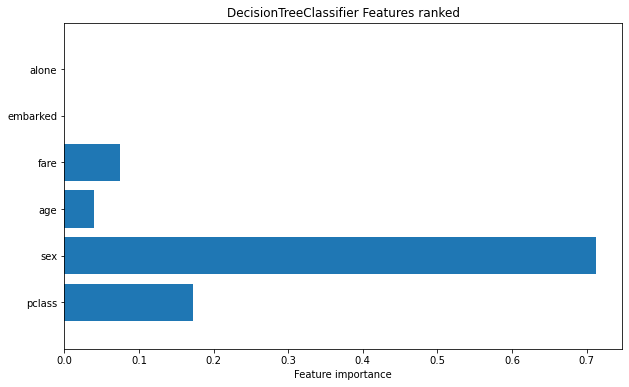

In [157]:
plt.figure(figsize=[10,6])
plt.title("DecisionTreeClassifier Features ranked")
plot_feature_importances(dt_cv.best_estimator_, X_train)

### Dictionary of all of the classifiers and their best/most-accurate estimators as a result of gridsearch with 5f-cv

In [158]:
crossvalscores

{'LogisticRegression': {'cv_score': 0.7783796626277025,
  'params': {'C': 0.1, 'penalty': 'l1'},
  'test_set_score': 0.7786259541984732},
 'KNeighborsClassifier': {'cv_score': 0.8013186029935853,
  'params': {'n_neighbors': 16},
  'test_set_score': 0.7684478371501272},
 'SVC': {'cv_score': 0.791488477072939,
  'params': {'C': 10, 'gamma': 'scale', 'kernel': 'poly'},
  'test_set_score': 0.8091603053435115},
 'RandomForestClassifier': {'cv_score': 0.7958660014255168,
  'params': {'max_depth': 11, 'n_estimators': 20},
  'test_set_score': 0.7888040712468194},
 'DecisionTreeClassifier': {'cv_score': 0.7980458541221193,
  'params': {'max_depth': 3},
  'test_set_score': 0.7786259541984732}}

###  Table of accuracy scores and corresponding parameters from each of the above estimators:

In [159]:
results = pd.DataFrame(crossvalscores).T.sort_values(by='test_set_score',ascending=False)
results

,cv_score,params,test_set_score
SVC,0.791488,"{'C': 10, 'gamma': 'scale', 'kernel': 'poly'}",0.80916
RandomForestClassifier,0.795866,"{'max_depth': 11, 'n_estimators': 20}",0.788804
LogisticRegression,0.77838,"{'C': 0.1, 'penalty': 'l1'}",0.778626
DecisionTreeClassifier,0.798046,{'max_depth': 3},0.778626
KNeighborsClassifier,0.801319,{'n_neighbors': 16},0.768448


## Final Takeaways:
- It appears that the SVC classifier, with the above hyperparameters, performs best on this dataset with no major signs of overfitting
- Sex (male or female) seems to be the most important determinant for surviving or not, at least for these classifiers. Followed by variable class (indicative of wealth/status).
- KNN performed well during the cross validation processs, but performance dropped on the final test_set score. Indicative of some overfitting
- Overall this project was great for testing the techniques taught in this course and simply exploring an interesting, yet unfortunate, dataset
- Related to my paper presentation, we were able to clearly identify (for some of the models) which features mattered most